# Tianyi Zhang 9598110243
------------------

## 1. Supervised, Semi-Supervised, and Unsupervised Learning

### a)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split


In [2]:
import sys
import warnings

warnings.filterwarnings('ignore')
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
data_folder = '..\\data'

In [4]:
def generate_data():
    filename = os.path.join(data_folder, 'wdbc.data')

    df = pd.read_csv(filename, header = None)
    df = df.sample(frac=1).reset_index(drop=True)

    x = df.iloc[:, 2:]
    y = df.iloc[:, 1]

    
    return x.to_numpy(), y.to_numpy()

In [5]:
def split_train_test(x, y, ratio):
    xM = x[y == 'M']
    xB = x[y == 'B']
    yM = y[y == 'M']
    yB = y[y == 'B']


    xtr = np.concatenate((xM[round(len(xM) * ratio):], xB[round(len(xB) * ratio):]), axis = 0)
    ytr = np.concatenate((yM[round(len(xM) * ratio):], yB[round(len(xB) * ratio):]), axis = 0)
    xte = np.concatenate((xM[:round(len(xM) * ratio)], xB[:round(len(xB) * ratio)]), axis = 0)
    yte = np.concatenate((yM[:round(len(xM) * ratio)], yB[:round(len(xB) * ratio)]), axis = 0)
    
    return xtr, ytr, xte, yte

In [6]:
x, y = generate_data()

xtr, ytr, xte, yte = split_train_test(x, y, ratio = 0.2)

print("shape of training data and label:", xtr.shape, ytr.shape)
print("shape of test data and label:", xte.shape, yte.shape)

shape of training data and label: (456, 30) (456,)
shape of test data and label: (113, 30) (113,)


### b)

#### 1)

In [7]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support as score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from tqdm import tqdm

from sklearn.metrics import roc_curve, auc

In [8]:
parameters = {"C": np.logspace(-3, 6, 10)}

In [9]:
acc_train = []
acc_test = []

matrix_train = {}
precision_train = []
recall_train = []
f_train = []
auc_train = []

matrix_test = {}
precision_test = []
recall_test = []
f_test = []
auc_test = []


y_train = {}
y_test = {}
prediction_train = {}
prediction_test = {}

In [10]:
for i in range(30):
    x, y = generate_data()

    x = MinMaxScaler().fit(x).transform(x)

    xtr, ytr, xte, yte = split_train_test(x, y, ratio = 0.2)
    yte = np.array([0 if x == 'M' else 1 for x in yte])
    ytr = np.array([0 if x == 'M' else 1 for x in ytr])

    y_train[i] = ytr
    y_test[i] = yte

    l1_svc = LinearSVC(penalty="l1", dual=False, max_iter=5000)
    gridCV = GridSearchCV(l1_svc, parameters, cv=5, n_jobs=-1)
    gridCV.fit(xtr, ytr)

    bestClf = gridCV.best_estimator_
    pred_tr = bestClf.predict(xtr)
    pred_te = bestClf.predict(xte)
    prediction_train[i] = pred_tr
    prediction_test[i] = pred_te

    matrix_tr = pd.crosstab(ytr, pred_tr, rownames=['True'], colnames=['Predicted'], margins=True)
    matrix_te = pd.crosstab(yte, pred_te, rownames=['True'], colnames=['Predicted'], margins=True)
    matrix_train[i] = matrix_tr
    matrix_test[i] = matrix_te

    precision_tr, recall_tr, f_tr, _ = score(ytr, pred_tr, average='binary', pos_label=1)
    precision_te, recall_te, f_te, _ = score(yte, pred_te, average='binary', pos_label=1)

    precision_train.append(precision_tr)
    recall_train.append(recall_tr)
    f_train.append(f_tr)
    precision_test.append(precision_te)
    recall_test.append(recall_te)
    f_test.append(f_te)

    fp_tr, tp_tr, _ = roc_curve(ytr, pred_tr)
    auc_tr = auc(fp_tr, tp_tr)
    auc_train.append(auc_tr)

    fp_te, tp_te, _ = roc_curve(yte, pred_te)
    auc_te = auc(fp_te, tp_te)
    auc_test.append(auc_te)

    acc_train.append(accuracy_score(ytr, pred_tr))
    acc_test.append(accuracy_score(yte, pred_te))


**For training data:**

In [11]:
print("average accuracy: ", np.average(acc_train))
print("average precision: ", np.average(precision_train))
print("average recall: ", np.average(recall_train))
print("average F1 -Score: ", np.average(f_train))
print("average AUC: ", np.average(auc_train))

average accuracy:  0.9844298245614034
average precision:  0.9817263142507772
average recall:  0.9937062937062938
average F1 -Score:  0.9876689821734764
average AUC:  0.9812649115590293


In [12]:
index = np.argmax(acc_train)
print("training confusion matrix:")
print("---------------")
print(matrix_train[index])

training confusion matrix:
---------------
Predicted    0    1  All
True                    
0          170    0  170
1            0  286  286
All        170  286  456


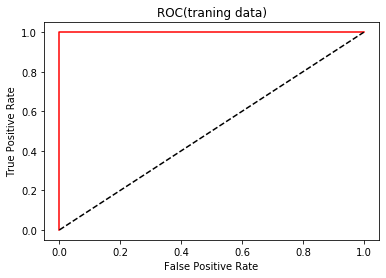

---------------
auc(training data):  1.0


In [13]:
fp, tp, thresholds = roc_curve(y_train[index], prediction_train[index])
area = auc(fp, tp)
plt.plot(fp, tp, color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC(traning data)")
plt.show()
print("---------------")
print("auc(training data): ", area)

**For test data:**

In [14]:
print("average accuracy: ", np.average(acc_test))
print("average precision: ", np.average(precision_test))
print("average recall: ", np.average(recall_test))
print("average F1 -Score: ", np.average(f_test))
print("average AUC: ", np.average(auc_test))

average accuracy:  0.9702064896755164
average precision:  0.9706567391430474
average recall:  0.9826291079812207
average F1 -Score:  0.9764518225593872
average AUC:  0.9659177285937849


In [15]:
print("test confusion matrix:")
print("---------------")
print(matrix_test[index])

training confusion matrix:
---------------
Predicted   0   1  All
True                  
0          40   2   42
1           4  67   71
All        44  69  113


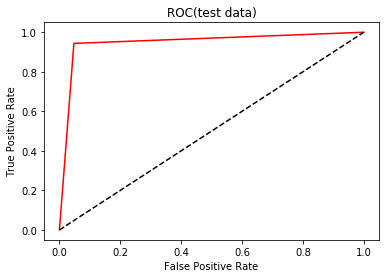

---------------
auc(test data):  0.948021462105969


In [16]:
fp, tp, thresholds = roc_curve(y_test[index], prediction_test[index])
area = auc(fp, tp)
plt.plot(fp, tp, color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC(test data)")
plt.show()
print("---------------")
print("auc(test data): ", area)

#### 2)

##### A)

In [17]:
x, y = generate_data()

x = MinMaxScaler().fit(x).transform(x)
xtr, ytr, xte, yte = split_train_test(x, y, ratio = 0.2)
label_x, label_y, unlabel_x, unlabel = split_train_test(xtr, ytr, ratio = 0.5)

In [18]:
l1_svc = LinearSVC(penalty="l1", dual=False, max_iter=5000)
gridCV = GridSearchCV(l1_svc, parameters, cv=5, n_jobs=-1)
gridCV.fit(label_x, label_y)

print("best penalty parameter: ", gridCV.best_params_)
print("test score:", gridCV.score(xte, yte))

best penalty parameter:  {'C': 1.0}
test score: 0.9557522123893806


##### B)

In [19]:
acc_train = []
acc_test = []

matrix_train = {}
precision_train = []
recall_train = []
f_train = []
auc_train = []

matrix_test = {}
precision_test = []
recall_test = []
f_test = []
auc_test = []


y_train = {}
y_test = {}
prediction_train = {}
prediction_test = {}

In [20]:
def semi_learning(label_xtr, label_ytr, unlabel_xtr, bestClf):
    for _ in range(unlabel_xtr.shape[0]):
        distance = np.absolute(bestClf.decision_function(unlabel_xtr))
        maxIndex = np.argmax(distance)
        datapoint = np.array(unlabel_xtr[maxIndex]).reshape(1, 30)
        pred = bestClf.predict(datapoint)

        unlabel_xtr = np.delete(unlabel_xtr, maxIndex, axis=0)
        label_xtr = np.append(label_xtr, datapoint, axis=0)
        label_ytr = np.append(label_ytr, pred, axis=0)

        bestClf.fit(label_xtr, label_ytr)
    return bestClf

In [21]:
for i in range(30):
    x, y = generate_data()

    x = MinMaxScaler().fit(x).transform(x)

    xtr, ytr, xte, yte = split_train_test(x, y, ratio = 0.2)
    label_xtr, label_ytr, unlabel_xtr, unlabel = split_train_test(xtr, ytr, ratio = 0.5)
    yte = np.array([0 if x == 'M' else 1 for x in yte])
    label_ytr = np.array([0 if x == 'M' else 1 for x in label_ytr])
    y_train[i] = label_ytr
    y_test[i] = yte
    
    l1_svc = LinearSVC(penalty="l1", dual=False, max_iter=5000)
    gridCV = GridSearchCV(l1_svc, parameters, cv=5, n_jobs=-1)
    gridCV.fit(label_xtr, label_ytr)
    
    bestClf = gridCV.best_estimator_
    bestClf = semi_learning(label_xtr.copy(), label_ytr.copy(), unlabel_xtr.copy(), bestClf)

    pred_tr = bestClf.predict(label_xtr)
    pred_te = bestClf.predict(xte)
    prediction_train[i] = pred_tr
    prediction_test[i] = pred_te

    matrix_tr = pd.crosstab(label_ytr, pred_tr, rownames=['True'], colnames=['Predicted'], margins=True)
    matrix_te = pd.crosstab(yte, pred_te, rownames=['True'], colnames=['Predicted'], margins=True)
    matrix_train[i] = matrix_tr
    matrix_test[i] = matrix_te

    precision_tr, recall_tr, f_tr, _ = score(label_ytr, pred_tr, average='binary', pos_label=1)
    precision_te, recall_te, f_te, _ = score(yte, pred_te, average='binary', pos_label=1)

    precision_train.append(precision_tr)
    recall_train.append(recall_tr)
    f_train.append(f_tr)
    precision_test.append(precision_te)
    recall_test.append(recall_te)
    f_test.append(f_te)

    fp_tr, tp_tr, _ = roc_curve(label_ytr, pred_tr)
    auc_tr = auc(fp_tr, tp_tr)
    auc_train.append(auc_tr)

    fp_te, tp_te, _ = roc_curve(yte, pred_te)
    auc_te = auc(fp_te, tp_te)
    auc_test.append(auc_te)

    acc_train.append(accuracy_score(label_ytr, pred_tr))
    acc_test.append(accuracy_score(yte, pred_te))


**For training data:**

In [22]:
print("average accuracy: ", np.average(acc_train))
print("average precision: ", np.average(precision_train))
print("average recall: ", np.average(recall_train))
print("average F1 -Score: ", np.average(f_train))
print("average AUC: ", np.average(auc_train))

average accuracy:  0.9862573099415204
average precision:  0.9820211855946874
average recall:  0.9965034965034965
average F1 -Score:  0.9891662566491876
average AUC:  0.9827615521733168


In [23]:
index = np.argmax(acc_train)
print("training confusion matrix:")
print("---------------")
print(matrix_train[index])

training confusion matrix:
---------------
Predicted   0    1  All
True                   
0          85    0   85
1           0  143  143
All        85  143  228


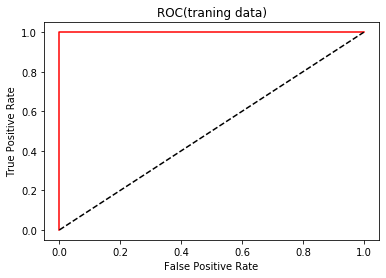

---------------
auc(training data):  1.0


In [24]:
fp, tp, thresholds = roc_curve(y_train[index], prediction_train[index])
area = auc(fp, tp)
plt.plot(fp, tp, color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC(traning data)")
plt.show()
print("---------------")
print("auc(training data): ", area)

**For test data:**

In [25]:
print("average accuracy: ", np.average(acc_test))
print("average precision: ", np.average(precision_test))
print("average recall: ", np.average(recall_test))
print("average F1 -Score: ", np.average(f_test))
print("average AUC: ", np.average(auc_test))

average accuracy:  0.9584070796460177
average precision:  0.9573488241934197
average recall:  0.9779342723004696
average F1 -Score:  0.9672339566216377
average AUC:  0.9516655488486474


In [26]:
print("test confusion matrix:")
print("---------------")
print(matrix_test[index])

training confusion matrix:
---------------
Predicted   0   1  All
True                  
0          40   2   42
1           4  67   71
All        44  69  113


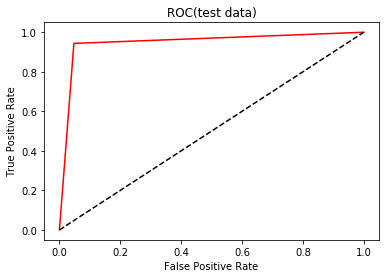

---------------
auc(test data):  0.948021462105969


In [27]:
fp, tp, thresholds = roc_curve(y_test[index], prediction_test[index])
area = auc(fp, tp)
plt.plot(fp, tp, color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC(test data)")
plt.show()
print("---------------")
print("auc(test data): ", area)

#### 3)

##### A)

In [28]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

In [29]:
acc_train = []

precision_train = []
recall_train = []
f_train = []
auc_train = []

In [30]:
for i in range(30):
    x, y = generate_data()

    x = MinMaxScaler().fit(x).transform(x)

    xtr, ytr, xte, yte = split_train_test(x, y, ratio = 0.2)
    yte = np.array([0 if x == 'M' else 1 for x in yte])
    ytr = np.array([0 if x == 'M' else 1 for x in ytr])

    kmeansClf = KMeans(n_clusters=2, init='random', n_init=10)
    cluster_tr = kmeansClf.fit_predict(xtr)

    precision_tr, recall_tr, f_tr, _ = score(ytr, cluster_tr, average='binary', pos_label=1)

    precision_train.append(precision_tr)
    recall_train.append(recall_tr)
    f_train.append(f_tr)
   
    fp_tr, tp_tr, _ = roc_curve(ytr, cluster_tr)
    auc_tr = auc(fp_tr, tp_tr)
    auc_train.append(auc_tr)

    acc_train.append(accuracy_score(ytr, cluster_tr))

In [31]:
print("max accuracy: ", np.max(acc_train))
print("max precision: ", np.max(precision_train))
print("max recall: ", np.max(recall_train))
print("max F1 -Score: ", np.max(f_train))
print("max AUC: ", np.max(auc_train))

max accuracy:  0.9407894736842105
max precision:  0.9331103678929766
max recall:  0.9790209790209791
max F1 -Score:  0.9538461538461539
max AUC:  0.9289387083504729


**To avoid trapped in a local minimum, we can set the random seed and run multiple times.**

##### B)

In [32]:
acc_train = []

matrix_train = {}
precision_train = []
recall_train = []
f_train = []
auc_train = []
prediction_train = {}
y_train = {}

In [33]:
from collections import Counter

In [34]:
for i in range(30):
    x, y = generate_data()

    x = MinMaxScaler().fit(x).transform(x)

    xtr, ytr, xte, yte = split_train_test(x, y, ratio = 0.2)
    yte = np.array([0 if x == 'M' else 1 for x in yte])
    ytr = np.array([0 if x == 'M' else 1 for x in ytr])

    kmeansClf = KMeans(n_clusters=2, init='random', n_init=10)
    cluster_tr = kmeansClf.fit_predict(xtr)

    posIndex = np.argsort(cdist(xtr, kmeansClf.cluster_centers_, 'euclidean')[:, 0], axis=0)[:30]
    negIndex = np.argsort(cdist(xtr, kmeansClf.cluster_centers_, 'euclidean')[:, 1], axis=0)[:30]

    ytr_pos_near = ytr[posIndex]
    ytr_neg_near = ytr[negIndex]
    pos = Counter(ytr_pos_near).most_common(1)[0][0]
    neg = Counter(ytr_neg_near).most_common(1)[0][0]
    
    majorityPolling = np.vectorize(lambda x: pos if x == 0 else neg)
    labels = majorityPolling(cluster_tr)
    
    prediction_train[i] = labels
    y_train[i] = ytr

    matrix_train[i] = pd.crosstab(ytr, labels, rownames=['True'], colnames=['Predicted'], margins=True)
    precision_tr, recall_tr, f_tr, _ = score(ytr, labels, average='binary', pos_label=1)

    precision_train.append(precision_tr)
    recall_train.append(recall_tr)
    f_train.append(f_tr)
   
    fp_tr, tp_tr, _ = roc_curve(ytr, labels)
    auc_tr = auc(fp_tr, tp_tr)
    auc_train.append(auc_tr)

    acc_train.append(accuracy_score(ytr, labels))

In [35]:
print("average accuracy: ", np.average(acc_train))
print("average precision: ", np.average(precision_train))
print("average recall: ", np.average(recall_train))
print("average F1 -Score: ", np.average(f_train))
print("average AUC: ", np.average(auc_train))

average accuracy:  0.9288742690058481
average precision:  0.9168018452006098
average recall:  0.9751748251748253
average F1 -Score:  0.945054386723656
average AUC:  0.9130776086658441


In [36]:
index = np.argmax(acc_train)
print("training confusion matrix:")
print("---------------")
print(matrix_train[index])

training confusion matrix:
---------------
Predicted    0    1  All
True                    
0          151   19  170
1            4  282  286
All        155  301  456


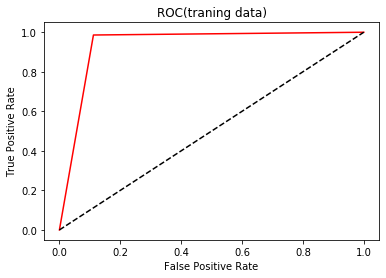

---------------
auc(training data):  0.9371246400658164


In [37]:
fp, tp, thresholds = roc_curve(y_train[index], prediction_train[index])
area = auc(fp, tp)
plt.plot(fp, tp, color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC(traning data)")
plt.show()
print("---------------")
print("auc(training data): ", area)

##### C)

In [38]:
acc_test = []

matrix_test = {}
precision_test = []
recall_test = []
f_test = []
auc_test = []
prediction_test = {}
y_test = {}

In [39]:
for i in range(30):
    x, y = generate_data()

    x = MinMaxScaler().fit(x).transform(x)

    xtr, ytr, xte, yte = split_train_test(x, y, ratio = 0.2)
    yte = np.array([0 if x == 'M' else 1 for x in yte])
    ytr = np.array([0 if x == 'M' else 1 for x in ytr])

    kmeansClf = KMeans(n_clusters=2, init='random', n_init=10)
    cluster_te = kmeansClf.fit_predict(xte)

    posDist = cdist(xte, kmeansClf.cluster_centers_, 'euclidean')[:, 0]
    negDist = cdist(xte, kmeansClf.cluster_centers_, 'euclidean')[:, 1]
    
    prediction_te = []
    for index, pred in enumerate(cluster_te):
        if pred == 1:
            prediction_te.append(1 if abs(posDist[index]) < abs(negDist[index]) else 0)
        else:
            prediction_te.append(0 if abs(posDist[index]) > abs(negDist[index]) else 1)
    
    majority = Counter(prediction_te).most_common(1)[0][0]
    if majority != 1:
        flip = np.vectorize(lambda x: 1 if x == 0 else 0)
        prediction_te = flip(prediction_te).tolist()
    prediction_test[i] = prediction_te
    y_test[i]= yte

    matrix_test[i] = pd.crosstab(yte, np.reshape(prediction_te, (-1,)), rownames=['True'], colnames=['Predicted'], margins=True)
    precision_te, recall_te, f_te, _ = score(yte, prediction_te, average='binary', pos_label=1)

    precision_test.append(precision_te)
    recall_test.append(recall_te)
    f_test.append(f_te)
   
    fp_te, tp_te, _ = roc_curve(yte, prediction_te)
    auc_te = auc(fp_te, tp_te)
    auc_test.append(auc_te)

    acc_test.append(accuracy_score(yte, prediction_te))

In [40]:
print("average accuracy: ", np.average(acc_test))
print("average precision: ", np.average(precision_test))
print("average recall: ", np.average(recall_test))
print("average F1 -Score: ", np.average(f_test))
print("average AUC: ", np.average(auc_test))

average accuracy:  0.9271386430678467
average precision:  0.9121212172035256
average recall:  0.9802816901408453
average F1 -Score:  0.9444032343203917
average AUC:  0.908791638721216


In [41]:
index = np.argmax(acc_test)
print("test confusion matrix:")
print("---------------")
print(matrix_test[index])

test confusion matrix:
---------------
Predicted   0   1  All
True                  
0          40   2   42
1           1  70   71
All        41  72  113


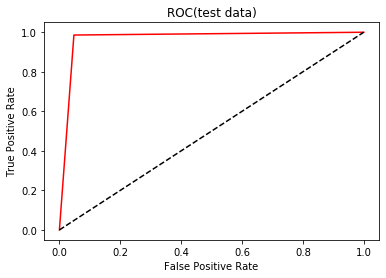

---------------
auc(test data):  0.9691482226693494


In [42]:
fp, tp, thresholds = roc_curve(y_test[index], prediction_test[index])
area = auc(fp, tp)
plt.plot(fp, tp, color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC(test data)")
plt.show()
print("---------------")
print("auc(test data): ", area)

#### 4)

##### A)

In [43]:
from sklearn.cluster import SpectralClustering

In [44]:
acc_train = []

precision_train = []
recall_train = []
f_train = []
auc_train = []

In [45]:
for i in range(30):
    x, y = generate_data()

    x = MinMaxScaler().fit(x).transform(x)

    xtr, ytr, xte, yte = split_train_test(x, y, ratio = 0.2)
    yte = np.array([0 if x == 'M' else 1 for x in yte])
    ytr = np.array([0 if x == 'M' else 1 for x in ytr])

    spectralClf = SpectralClustering(n_clusters=2, affinity="rbf", n_init=10, gamma=1)
    cluster_tr = spectralClf.fit_predict(xtr)

    precision_tr, recall_tr, f_tr, _ = score(ytr, cluster_tr, average='binary', pos_label=1)

    precision_train.append(precision_tr)
    recall_train.append(recall_tr)
    f_train.append(f_tr)
   
    fp_tr, tp_tr, _ = roc_curve(ytr, cluster_tr)
    auc_tr = auc(fp_tr, tp_tr)
    auc_train.append(auc_tr)

    acc_train.append(accuracy_score(ytr, cluster_tr))

In [46]:
print("max accuracy: ", np.max(acc_train))
print("max precision: ", np.max(precision_train))
print("max recall: ", np.max(recall_train))
print("max F1 -Score: ", np.max(f_train))
print("max AUC: ", np.max(auc_train))

max accuracy:  0.8706140350877193
max precision:  0.8328445747800587
max recall:  0.9965034965034965
max F1 -Score:  0.9059011164274322
max AUC:  0.8288564376799671


##### B)

In [47]:
acc_train = []

matrix_train = {}
precision_train = []
recall_train = []
f_train = []
auc_train = []
prediction_train = {}
y_train = {}

In [48]:
for i in range(30):
    x, y = generate_data()

    x = MinMaxScaler().fit(x).transform(x)

    xtr, ytr, xte, yte = split_train_test(x, y, ratio = 0.2)
    yte = np.array([0 if x == 'M' else 1 for x in yte])
    ytr = np.array([0 if x == 'M' else 1 for x in ytr])

    spectralClf = SpectralClustering(n_clusters=2, affinity="rbf", n_init=10, gamma=1)
    cluster_tr = spectralClf.fit_predict(xtr)

    posIndex = np.argwhere(cluster_tr == 1).reshape(-1, )
    negIndex = np.argwhere(cluster_tr == 0).reshape(-1, )

    ytr_pos = ytr[posIndex]
    ytr_neg = ytr[negIndex]
    pos = Counter(ytr_pos).most_common(1)[0][0]
    neg = Counter(ytr_neg).most_common(1)[0][0]
    cluster_tr[posIndex] = pos
    cluster_tr[negIndex] = neg

    
    prediction_train[i] = cluster_tr
    y_train[i] = ytr

    matrix_train[i] = pd.crosstab(ytr, cluster_tr, rownames=['True'], colnames=['Predicted'], margins=True)
    precision_tr, recall_tr, f_tr, _ = score(ytr, cluster_tr, average='binary', pos_label=1)

    precision_train.append(precision_tr)
    recall_train.append(recall_tr)
    f_train.append(f_tr)
   
    fp_tr, tp_tr, _ = roc_curve(ytr, cluster_tr)
    auc_tr = auc(fp_tr, tp_tr)
    auc_train.append(auc_tr)

    acc_train.append(accuracy_score(ytr, cluster_tr))

In [49]:
print("average accuracy: ", np.average(acc_train))
print("average precision: ", np.average(precision_train))
print("average recall: ", np.average(recall_train))
print("average F1 -Score: ", np.average(f_train))
print("average AUC: ", np.average(auc_train))

average accuracy:  0.8573099415204677
average precision:  0.8185439561464534
average recall:  0.9932400932400933
average F1 -Score:  0.897359259322796
average AUC:  0.8109337721102426


In [50]:
index = np.argmax(acc_train)
print("training confusion matrix:")
print("---------------")
print(matrix_train[index])

training confusion matrix:
---------------
Predicted    0    1  All
True                    
0          123   47  170
1            3  283  286
All        126  330  456


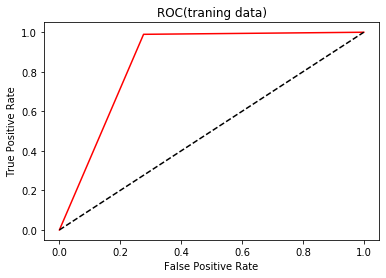

---------------
auc(training data):  0.8565199506375978


In [51]:
fp, tp, thresholds = roc_curve(y_train[index], prediction_train[index])
area = auc(fp, tp)
plt.plot(fp, tp, color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC(traning data)")
plt.show()
print("---------------")
print("auc(training data): ", area)

##### C)

In [52]:
acc_test = []

matrix_test = {}
precision_test = []
recall_test = []
f_test = []
auc_test = []
prediction_test = {}
y_test = {}

In [53]:
for i in range(30):
    x, y = generate_data()

    x = MinMaxScaler().fit(x).transform(x)

    xtr, ytr, xte, yte = split_train_test(x, y, ratio = 0.2)
    yte = np.array([0 if x == 'M' else 1 for x in yte])
    ytr = np.array([0 if x == 'M' else 1 for x in ytr])

    spectralClf = SpectralClustering(n_clusters=2, affinity="rbf", n_init=10, gamma=1)
    cluster_te = spectralClf.fit_predict(xte)

    posIndex = np.argwhere(cluster_te == 1).reshape(-1, )
    negIndex = np.argwhere(cluster_te == 0).reshape(-1, )

    yte_pos = yte[posIndex]
    yte_neg = yte[negIndex]
    pos = Counter(yte_pos).most_common(1)[0][0]
    neg = Counter(yte_neg).most_common(1)[0][0]
    cluster_te[posIndex] = pos
    cluster_te[negIndex] = neg
    
    prediction_test[i] = prediction_te
    y_test[i]= yte

    matrix_test[i] = pd.crosstab(yte, cluster_te, rownames=['True'], colnames=['Predicted'], margins=True)
    precision_te, recall_te, f_te, _ = score(yte, cluster_te, average='binary', pos_label=1)

    precision_test.append(precision_te)
    recall_test.append(recall_te)
    f_test.append(f_te)
   
    fp_te, tp_te, _ = roc_curve(yte, cluster_te)
    auc_te = auc(fp_te, tp_te)
    auc_test.append(auc_te)

    acc_test.append(accuracy_score(yte, cluster_te))

In [54]:
print("average accuracy: ", np.average(acc_test))
print("average precision: ", np.average(precision_test))
print("average recall: ", np.average(recall_test))
print("average F1 -Score: ", np.average(f_test))
print("average AUC: ", np.average(auc_test))

average accuracy:  0.8513274336283186
average precision:  0.8202695161918504
average recall:  0.996244131455399
average F1 -Score:  0.8971539265625379
average AUC:  0.8012966689023028


In [55]:
index = np.argmax(acc_test)
print("test confusion matrix:")
print("---------------")
print(matrix_test[index])

test confusion matrix:
---------------
Predicted   0   1  All
True                  
0          38   4   42
1           1  70   71
All        39  74  113


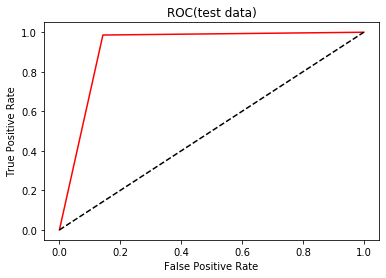

---------------
auc(test data):  0.9215291750503019


In [56]:
fp, tp, thresholds = roc_curve(y_test[index], prediction_test[index])
area = auc(fp, tp)
plt.plot(fp, tp, color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC(test data)")
plt.show()
print("---------------")
print("auc(test data): ", area)

#### 5)

**For supervised learning(test data):**

average accuracy:  0.9702064896755164

average precision:  0.9706567391430474

average recall:  0.9826291079812207

average F1 -Score:  0.9764518225593872

average AUC:  0.9659177285937849

**For semi-supervised learning(test data):**

average accuracy:  0.9584070796460177

average precision:  0.9573488241934197

average recall:  0.9779342723004696

average F1 -Score:  0.9672339566216377

average AUC:  0.9516655488486474


**For unsupervised learning:**

average accuracy:  0.9271386430678467

average precision:  0.9121212172035256

average recall:  0.9802816901408453

average F1 -Score:  0.9444032343203917

average AUC:  0.908791638721216


**We can find that supervised learning performs a little better than semi-supervised learning, and both of them are better than unsupervised learning.**

**And for Spectral Clustering, I don't think it's a good choice to use it here. In this issue, I think k-means is better.**

## 2. Active Learning Using Support Vector Machines

### a)

In [57]:
filename2 = os.path.join(data_folder, 'data_banknote_authentication.txt')

In [58]:
from sklearn.preprocessing import StandardScaler

In [59]:
df2 = pd.read_csv(filename2, header = None)
print(df2.head())

         0       1       2        3  4
0  3.62160  8.6661 -2.8073 -0.44699  0
1  4.54590  8.1674 -2.4586 -1.46210  0
2  3.86600 -2.6383  1.9242  0.10645  0
3  3.45660  9.5228 -4.0112 -3.59440  0
4  0.32924 -4.4552  4.5718 -0.98880  0


In [60]:
data = df2.sample(frac=1).reset_index(drop=True)

x = data.iloc[:, :4]
y = data.iloc[:, 4].to_numpy()
x = StandardScaler().fit(x).transform(x)

xte = x[:472]
xtr = x[472:]
yte = y[:472]
ytr = y[472:]

print("shape of training data:", xtr.shape, ytr.shape)
print("shape of test data:", xte.shape, yte.shape)

shape of training data: (900, 4) (900,)
shape of test data: (472, 4) (472,)


### b)

#### 1)

In [61]:
error_pass = []

In [62]:
import random

In [63]:
for i in tqdm(range(50)):
    error = []
    length = len(xtr)
    index = np.arange(0, length)
    
    xtr_pool = np.array([[]])
    ytr_pool = np.array([])
    
    for __ in range(90):
        indexes = random.sample(index.tolist(), 10)
        check = True if len(Counter(ytr[indexes]).keys()) == 2 else False
        while not check:
            indexes = random.sample(index.tolist(), 10)
            check = True if len(Counter(ytr[indexes]).keys()) == 2 else False
        index = np.setdiff1d(index, np.array(indexes))
        
        xtr_pool = np.append(xtr_pool, xtr[indexes]).reshape(-1, 4)
        ytr_pool = np.append(ytr_pool, ytr[indexes]).reshape(-1, )
        l1_scv = LinearSVC(penalty="l1", dual=False, max_iter=5000)
        gridCV = GridSearchCV(l1_scv, parameters, cv=5, n_jobs=-1, scoring='accuracy')
        gridCV.fit(xtr_pool, ytr_pool)
        error.append(1 - gridCV.score(xte, yte))

    error_pass.append(error)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [15:53<00:00, 19.08s/it]


#### 2)

In [64]:
error_act = []

In [65]:
for i in tqdm(range(50)):
    error = []
    length = len(xtr)
    index = np.arange(0, length)
    
    xtr_pool = np.array([[]])
    ytr_pool = np.array([])
    
    indexes = random.sample(index.tolist(), 10)
    check = True if len(Counter(ytr[indexes]).keys()) == 2 else False
    while not check:
        indexes = random.sample(index.tolist(), 10)
        check = True if len(Counter(ytr[indexes]).keys()) == 2 else False
    index = np.setdiff1d(index, np.array(indexes))

    xtr_pool = np.append(xtr_pool, xtr[indexes]).reshape(-1, 4)
    ytr_pool = np.append(ytr_pool, ytr[indexes]).reshape(-1, )
    l1_scv = LinearSVC(penalty="l1", dual=False, max_iter=5000)
    gridCV = GridSearchCV(l1_scv, parameters, cv=5, n_jobs=-1, scoring='accuracy')
    gridCV.fit(xtr_pool, ytr_pool)
    error.append(1 - gridCV.score(xte, yte))
        
    for __ in range(89):
        x_remaining = xtr[index]
        distances = gridCV.best_estimator_.decision_function(x_remaining).reshape(-1, 1)
        x_remaining = np.hstack((x_remaining, abs(distances)))
        indexes_near = x_remaining[:, 4].argsort()[:10]
        x_near = xtr[indexes_near]
        y_near = ytr[indexes_near]
        index = np.setdiff1d(index, np.array(indexes_near))
        
        xtr_pool = np.append(xtr_pool, x_near).reshape(-1, 4)
        ytr_pool = np.append(ytr_pool, y_near).reshape(-1, )

        l1_scv = LinearSVC(penalty="l1", dual=False, max_iter=5000)
        gridCV = GridSearchCV(l1_scv, parameters, cv=5, n_jobs=-1, scoring='accuracy')
        gridCV.fit(xtr_pool, ytr_pool)
        error.append(1 - gridCV.score(xte, yte))

    error_act.append(error)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [18:04<00:00, 21.68s/it]


### c)

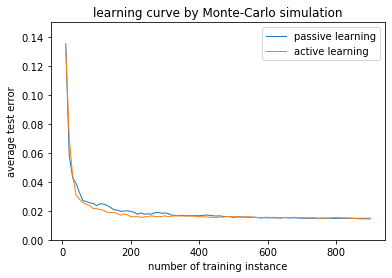

In [66]:
avg_error_pass = np.average(np.array(error_pass), axis=0)
avg_error_act = np.average(np.array(error_act), axis=0)
plt.plot(np.arange(10, 901, 10), avg_error_pass, marker='', linewidth=1, label="passive learning")
plt.plot(np.arange(10, 901, 10), avg_error_act, marker='', linewidth=1, label="active learning")

plt.xlabel('number of training instance')
plt.ylabel('average test error')
plt.ylim([0, 0.15])
plt.title("learning curve by Monte-Carlo simulation")
plt.legend()
plt.show()

**We can find that active learning curve decreases more quickly, but the final test error is very similar with the passive learning curve. So, I think active learning is just a little better than passive learning in this issue.** 